# Week 2: Neural network in AWS SageMaker

**Dr. Upul Senanayake and Dr. Kelly Trinh**

Today we
  - **learn to use AWS SageMaker to build and train a MLP**. 



### Fashion MNIST data

MNIST fashion data contains 60,000 small square 28 × 28 pixel grayscale images of 10 types of clothing:

   - 0: T-shirt/top
   - 1: Trouser
   - 2: Pullover
   - 3: Dress
   - 4: Coat
   - 5: Sandal
   - 6: Shirt
   - 7: Sneaker
   - 8: Bag
   - 9: Ankle boot
   
**Our task is**

 - **to construct a simple MLP to classify the type of clothing using Keras & Tensorflow**



### A. Sign up for an AWS account 
If you don't already have an account [sign up here](https://portal.aws.amazon.com/billing/signup#/start)

### B. Create an AWS SageMaker instance

We will create a notebook instance that is used to download and process the data. 

1. Sign in to the [AWS SageMaker console](https://aws.amazon.com/console/) as a Root user


2. Navigate to Notebook instances in the left menu pane, and select Create notebook instance. (See lecture slides of Week 7)

3. Specify your Notebook instance settings
   - Give your new instance a suitable name *e.g.* JCUAlpha
   - Select the **instance type** as **ml.t2.medium**. Note: This one is free. If you need intances with different capacity you can select it here. 
   - Leave **elastic inference** as **default selection (none)**
   
4. In the Permissions and encryption section, **create a new IAM role**. Leave the selections as default and select **create role**. Leave the **root access enabled as default**. 

5. Choose **Create Notebook instance**.

6. The **Notebook instances** section will now open, and the new notebook instance is displayed. The status will be *pending*, and this status will change to *InService* when the notebook is ready. 

  

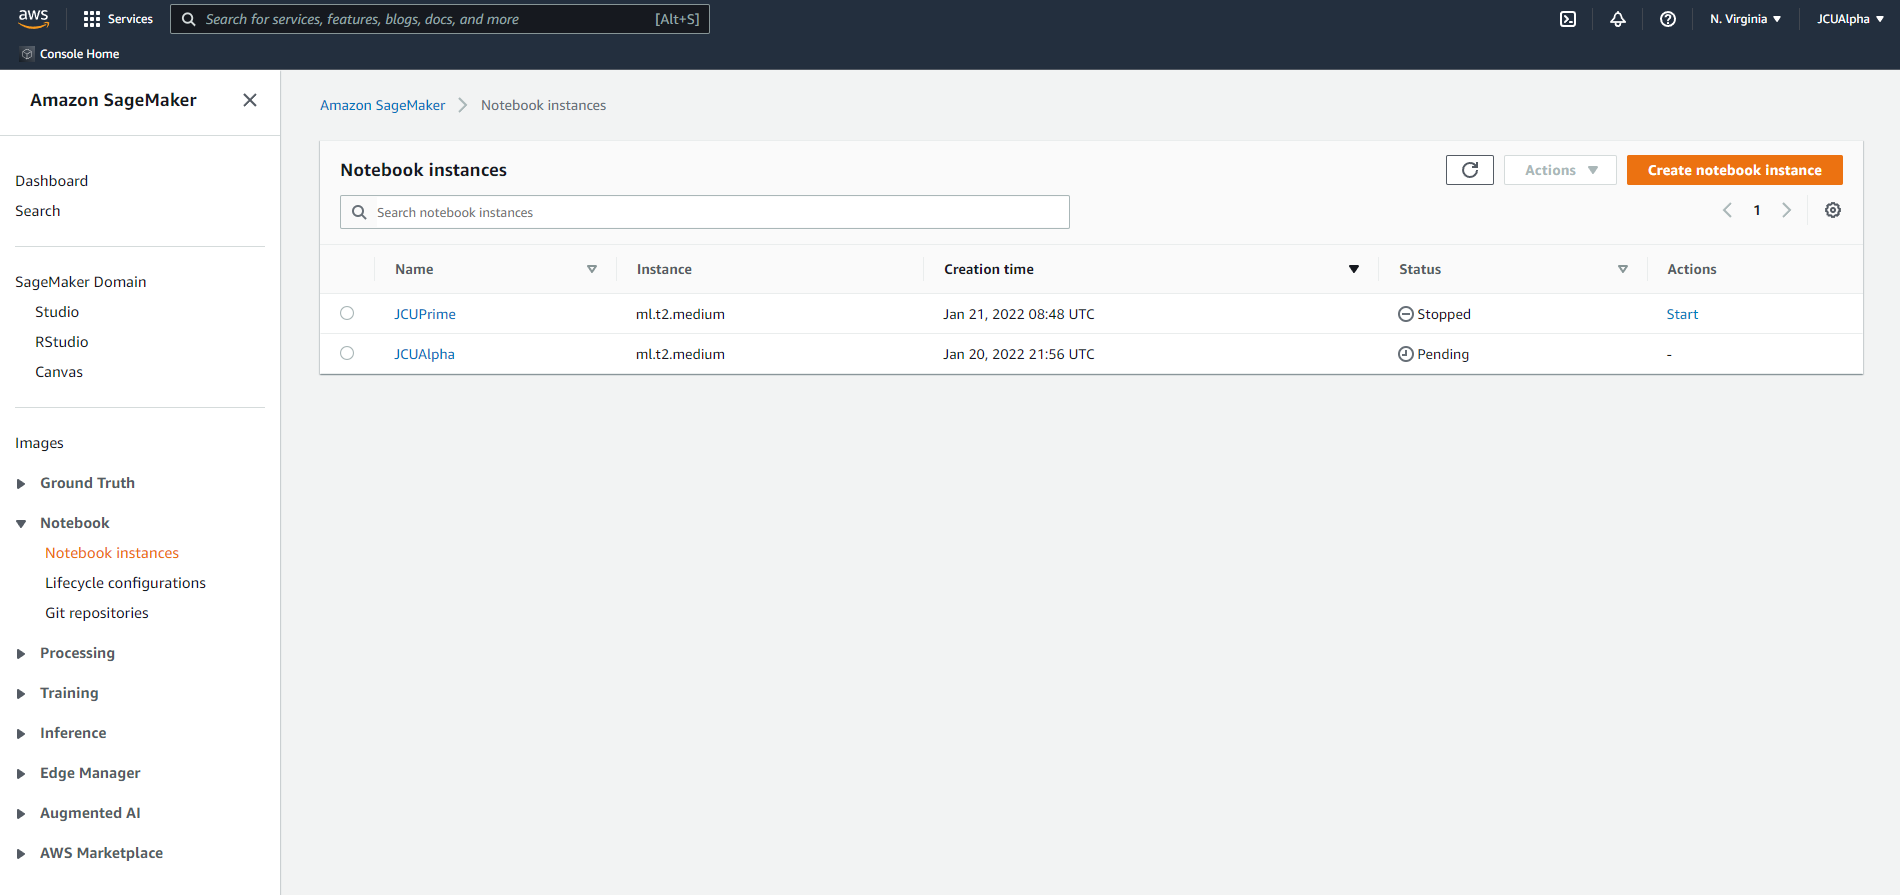

### C. Preparing the data
We will now use our new notebook instance to load, prepare the Fashion MNIST data and upload the data to Amazon S3. 

1. When your notebook instance status changes to **InService**, select **Open Jupyter**

Note, you can select Open JupyterLab to get a heap of tutorials etc... 

2. In the Notebook Instance, and either; 
    - create a new notebook using **new** and select the **kernel conda_tensorflow_p36** configuration. A new code cell will appear in your Jupyter notebook. Run the following code by copying and pasting it into your Notebook, or;
    - upload existing jupyter notebooks & python scripts using **upload**. Select the **conda_tensorflow_p36** kernal when prompted.

Before you start: Check directory structure and modify permissions

In [1]:
%%sh
ls -l

total 596
drwxrwxr-x 2 ec2-user ec2-user   4096 Jan 21 02:47 data
-rw-rw-r-- 1 ec2-user ec2-user 510703 Jan 28 08:14 JCUAlpha.ipynb
drwx------ 2 ec2-user ec2-user  16384 Jan 20 22:02 lost+found
-rw-rw-r-- 1 ec2-user ec2-user  76093 Jan 28 07:22 Sagemaker_Notebook.PNG


Do you have a lost+found folder with root group and owner? If so, you will need to change the permissions of to lost+found to prevent future errors. 

In [2]:
%%sh
sudo chown ec2-user lost+found

In [3]:
%%sh
ls -l

total 596
drwxrwxr-x 2 ec2-user ec2-user   4096 Jan 21 02:47 data
-rw-rw-r-- 1 ec2-user ec2-user 508853 Jan 28 07:54 JCUAlpha.ipynb
drwx------ 2 ec2-user ec2-user  16384 Jan 20 22:02 lost+found
-rw-rw-r-- 1 ec2-user ec2-user  76093 Jan 28 07:22 Sagemaker_Notebook.PNG


In [4]:
%%sh
sudo chgrp ec2-user lost+found

In [5]:
%%sh
ls -l 

total 596
drwxrwxr-x 2 ec2-user ec2-user   4096 Jan 21 02:47 data
-rw-rw-r-- 1 ec2-user ec2-user 508853 Jan 28 07:54 JCUAlpha.ipynb
drwx------ 2 ec2-user ec2-user  16384 Jan 20 22:02 lost+found
-rw-rw-r-- 1 ec2-user ec2-user  76093 Jan 28 07:22 Sagemaker_Notebook.PNG


### Set up our AWS-SageMaker environment:

In [6]:
# We first need to import the necessary libraries and define some environment variables  
# Import sagemaker and retrieve IAM role, which determines your user identity and permissions

import sagemaker #import sagemaker
print(sagemaker.__version__) #print the sagemaker version
sess = sagemaker.Session() ### Manages interactions with the Amazon SageMaker APIs and 
                           ### any other AWS services needed e.g. S3
role = sagemaker.get_execution_role() ### Get and save the IAM role as environment variable

2.72.1


### Load Keras, TensorFlow and other packages

In [7]:
## Import os, keras, numpy, pyplot and the fashion MNIST data 
import os #https://docs.python.org/3/library/os.html
import tensorflow as tf
from tensorflow import keras
from keras.datasets import fashion_mnist
import numpy as np
from matplotlib import pyplot 
from keras import backend as K
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.utils import to_categorical

Using TensorFlow backend.


### Download Fashion MNIST data from Keras

In [8]:
(x_train,y_train), (x_test,y_test)  = fashion_mnist.load_data()

4423680/4422102 [==============================] - 1s 0us/step


x_train_shape (60000, 28, 28)
x_train_type uint8
x_test_shape (10000, 28, 28)


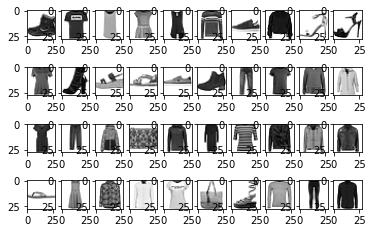

In [9]:
# Take a quick look at data 
#Each image is represented as a 28x28 pixel grayscale images
## View shape and type of data
print("x_train_shape", x_train.shape)
print("x_train_type", x_train.dtype)
print("x_test_shape", x_test.shape)
# plot some raw pixel data
n_rows = 4
n_cols = 10
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols*row +col
        pyplot.subplot(n_rows,n_cols,index+1)
        pyplot.imshow(x_train[index], cmap="binary")

### Next we need to create a local directory for storing the training and test data separately

In [10]:
# Create local directory for the data and save the test and training data here

os.makedirs("./data", exist_ok=True)
np.savez('./data/training', image = x_train, label=y_train)
np.savez('./data/test', image=x_test, label=y_test)

In [11]:
ls -l data ## Check that the directories have been created

total 53668
-rw-rw-r-- 1 ec2-user ec2-user  7850506 Jan 28 08:25 test.npz
-rw-rw-r-- 1 ec2-user ec2-user 47100506 Jan 28 08:25 training.npz


#### Build an MLP Image Classifier using the Keras Sequential API

Sequential models are the simplest kind of Keras model for neural networks. They are composed of a single stack of layers connected sequentially, and is called the Sequential API. 

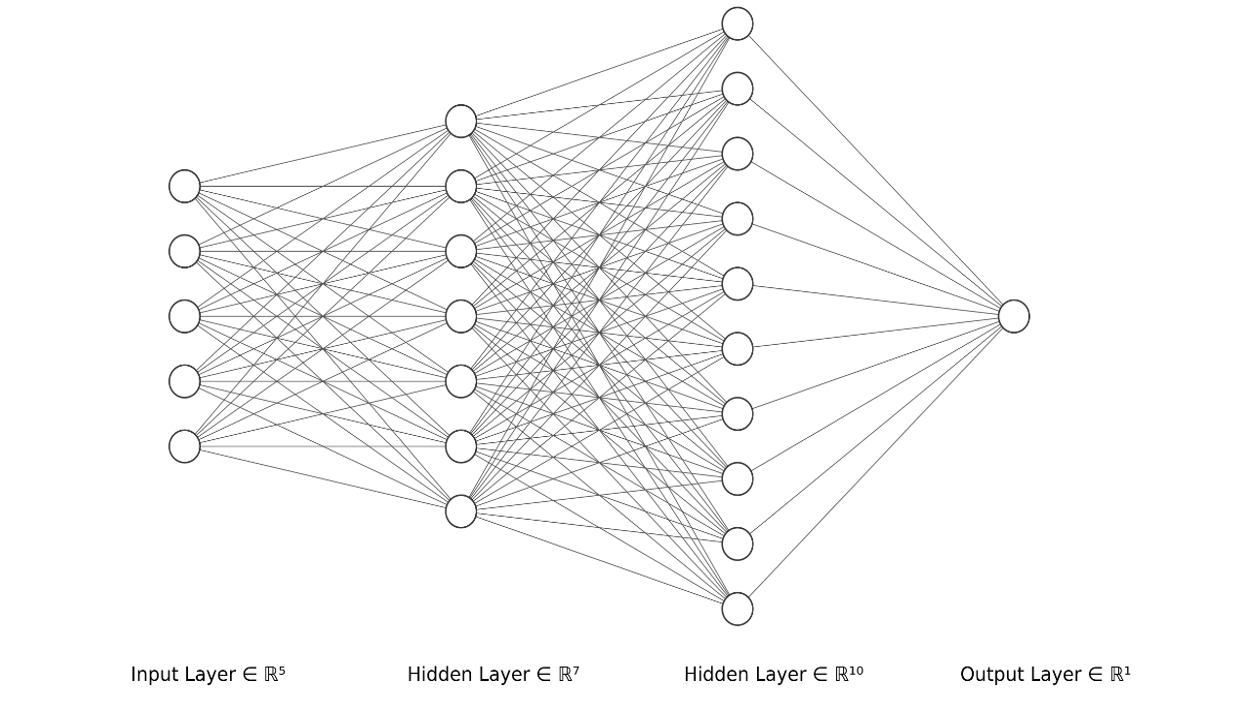

#### Steps needed 

1. *Shape:* ensuring the dataset have the right shape for TensorFlow
2. *Normalisation:* normalising the data, *i.e.* tranform [0-255] pixels values to [0-1] value
3. *One-Hot Encode Class Labels:* convert category labels using one-hot encoding
4. *Building the model:* build a sequential model in Keras
5. *Training:* train the model
6. *Test:* test the model and make predictions 

#### Steps 1, 2 & 3: Shape, Normalise and One Hot Encoding 

In [12]:
# loading the datasets
## note: the datasets were already loaded here using fashion_mnist.load_data()
##       this is to demonstrate how you would load your own data

x_train = np.load(os.path.join("./data", 'training.npz'))['image'] #load training data images using numpy
y_train = np.load(os.path.join("./data", 'training.npz'))['label'] #load training data classes 
x_test = np.load(os.path.join("./data", 'test.npz'))['image'] #load testing data images 
y_test = np.load(os.path.join("./data", 'test.npz'))['label'] #load testing data classes 

# define image dimensions
img_rows, img_cols = 28, 28 #images are 28*28 pixels

# 1. Shape: Keras can have different backends (Tensorflow, MXNet etc). We will be using Tensorflow backend which needs image channels last, e.g. (batch size, width, height, channels)
if K.image_data_format() == 'channels_last': #K.image_data_format() return a string, either 'channels_first' or 'channels_last'. This confirms the Keras backend. 
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    batch_norm_axis = -1
else:
    # Keras is configured with channels first (Apache MXNet backend)
    print('Channels first, exiting')
    exit(-1)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [13]:
# 2. Normalize pixel values i.e. tranform [0-255] pixels values to [0-1] value 
x_train = x_train.astype('float32') #convert to data type float32
x_test = x_test.astype('float32') #convert to data type float32
x_train /= 255 #divide by 255 to rescale [0-255] to [0-1]
x_test /= 255 #divide by 255 to rescale [0-255] to [0-1]

In [14]:
# 3. One Hot Encoding: Convert class vectors to binary class matrices
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

print("y_test:", y_test)

y_test: [[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


#### Step 4: Building a sequential VNN (Vanilla Neural Network; ie: MLP) model in Keras 

Note: First we will go thorugh building the model on a local machine. Next, we will go through how to run in a script to prepare for using AWS in Week 2

We will build a VNN with the following structure:

- Number of Hidden layers = 2: The first hidden layer contains 64 neurons while the second layer includes 32 neurons. 
- Activation function: Both hidden layers will use the Relu activation function
- Optimizer: Stochastic Gradient Descent

In [15]:
# First, we define the model structure
model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[28, 28, 1]),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dense(num_classes, activation="softmax")
    ])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [16]:
# Second, we compile the model
# Compiling a model defines the loss function, the optimizer and the metrics
model.compile(loss=categorical_crossentropy,
                  optimizer=SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True),
                  metrics=['accuracy',
                           tf.keras.metrics.Precision(),
                           tf.keras.metrics.Recall()])

#### Step 5: Training the model 

Now we are ready to train the model

In [17]:
history = model.fit(x_train, y_train, batch_size=10, # pass in input features and classes, 
                    validation_split=0.1, # The model will set apart this fraction of the training data, 
                                # will not train on it, and will evaluate the loss and any model metrics 
                                # on this data at the end of each epoch. The validation data is selected 
                                # from the last samples in the x and y data provided, before shuffling. 
                     epochs=2) #how many iterations over the entire training dataset 

# note: we will talk about how to tune these parameters in week 3

# we can use the summary() function to display a summary of the model
model.summary()



[2022-01-28 08:45:03.126 ip-172-16-39-227:21836 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-01-28 08:45:03.361 ip-172-16-39-227:21836 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
Train on 54000 samples, validate on 6000 samples
Epoch 1/2
54000/54000 [==============================] - 17s 313us/sample - loss: 0.6106 - acc: 0.7900 - precision: 0.8633 - recall: 0.7016 - val_loss: 0.4647 - val_acc: 0.8360 - val_precision: 0.8780 - val_recall: 0.7892
Epoch 2/2
54000/54000 [==============================] - 15s 270us/sample - loss: 0.4382 - acc: 0.8445 - precision: 0.8815 - recall: 0.8074 - val_loss: 0.4409 - val_acc: 0.8382 - val_precision: 0.8754 - val_recall: 0.8022
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
____________

(0.0, 1.0)

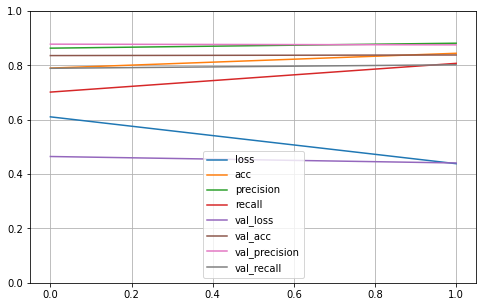

In [18]:
## We can plot the model performance with pandas and matlibplot.pyplot

import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8,5))
pyplot.grid(True)
pyplot.gca().set_ylim(0,1) #set the limits of the y axis

# At this this stage, you could go back and tune the hyperparameters of your model. 
# This is a discussion for week 3
# Note, this should be done BEFORE you evaluate your model on the test set or your estimate of error
# will be too optimistic!

In [19]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss    :', score[0])
print('Test accuracy:', score[1])
print('Test precision:', score[2])
print('Test recall:', score[3])

Test loss    : 0.4343997066497803
Test accuracy: 0.8453
Test precision: 0.87929547
Test recall: 0.8137


### Shut down notebook instance!!!!


In [ ]:
import boto3

sagemaker_client = boto3.client('sagemaker')
sagemaker_client.stop_notebook_instance(
    NotebookInstanceName='JCUAplha' 
)

### References

- Tensorflow : https://www.tensorflow.org/guide/keras/sequential_model
- Machine Learning Mastery: https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-fashion-mnist-clothing-classification/
- Hands-on Machine Learning with Scikit-Learn, Keras & Tensorflow by Aurélion Géron